# Markov processes

## The concept of state in a process

- We refer to internal representation of the Process at time $t$ as the <i>State</i> of the Process at time $t$ and denote it as $S_t$. We are interested in the probability of the next State $S_{t+1}$, given the present State $S_t$ and the past States $S_0, S_1, ..., S_{t-1}$, i.e., $\mathbb{P}[S_{t+1}|S_t, S_{t-1},..., S_0]$.

## Understanding Markov property from stock price exmaples

- We will be learning about Markov Processses in this chapter, and these Processes have States that possess a property known as the Markov Property. So we will now learn about the Markov Property of States.

- Let us assume that from time step $t$ to the next time step $t+1$, the stock price can either go up by 1 or go down by 1, i.e., the only two outcomes for $X_{t+1}$ are $X_t+1$ or $X_t-1$. To understand the random evolution of the stock prices in time, we just need to quantify the probability of an up-move $\mathbb{P}[X_{t+1}=X_t+1]$ since the probability of a down-move $\mathbb{R}[X_{t+1}=X_t-1]=1-\mathbb{P}[X_{t+1}=X_t+1]$. We will consider 3 different processes for the evolution of stock prices.

### Process 1
$$\mathbb{P}[X_{t+1}=X_t+1]=\frac{1}{1+e^{-\alpha_1(L-X_t)}}$$

- where $L$ is an arbitrary reference level and $\alpha_1\in \mathbb{R}\ge 0$ is a "pull strength" parameter. This probability is defined as a logistic function of $L-X$ with the stepness of the logistic function controlled by the parameter $\alpha_1$.

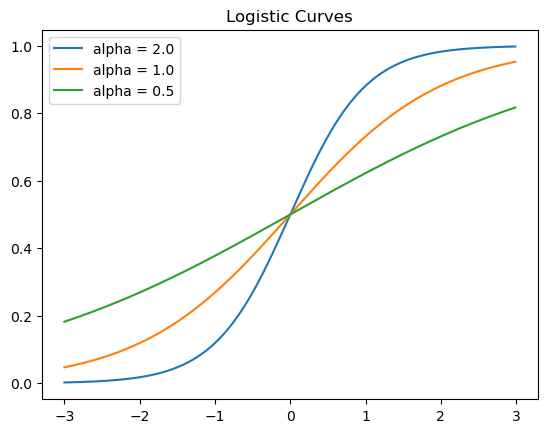

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

X = np.arange(-3, 3, 0.01)

def sigmoid(x, alpha):
    return 1 / (1 + np.exp(-x * alpha))

y1 = sigmoid(X, 2.0)
y2 = sigmoid(X, 1.0)
y3 = sigmoid(X, 0.5)

plt.plot(X, y1, label='alpha = 2.0')
plt.plot(X, y2, label='alpha = 1.0')
plt.plot(X, y3, label='alpha = 0.5')
plt.legend()
plt.title("Logistic Curves")
plt.show()


- The way to interpret this logistic function of $L-X_t$ is: if $X_t$ is greater than the reference level $L$ (making $\mathbb{P}[X_{t+1}=X_t+1]<0.5)$, then there is more of a down-pull than an up-pull. Likewise, if $X_t$ is less than $L$, then there is more of an up-pull. The extent of the pull is controlled by the magnitude of the parameter $\alpha_1$. We refer to this behavior as mean-reverting behavior, meaning the stock price tends to revert to the mean.

- We can model the State $S_t=X_t$ and note that the probabilities of the next State $S_{t+1}$ depend only on the current State $S_t$ and not on the previous States $S_0, S_1, ..., S_{t-1}$.

$$ \mathbb{P}[S_{t+1}|S_t, S_{t-1}, ..., S_0]=\mathbb{P}[S_{t+1}|S_t] \text{ for all } t\ge0$$

- We call this the Markov Property of States, or simply that these are Markov States.

- Let us code this up.

    - Firstly, we create a dataclass to represent the dynamics of this process. The dataclass `Process1` contains two attributes `level_param`: `int` and `alpha1: float = 0.25` to represent $L$ and $\alpha_1$.

    - It contains the method `up_prob` to calculate $\mathbb{P}[X_{t+1}=X_t+1]$ and the method `next_state`, which samples from a Bernoulli distribution (whose probability is obtained from the method `up_prob`) and creates the next state $S_{t+1}$ from the current state $S_t$.

    - Note the. nested dataclass `State` meant to represent the state pf Process 1 (its only attribute `price: int` reflects the fact that the state consits of only the current price.)

In [2]:
import numpy as np
from dataclasses import dataclass

@dataclass
class Process1:
    @dataclass
    class State:
        price: int
    level_param: int    # level to which price mean-reverts
    alpha1: float = 0.25 # strength of mean-reversion (non-negaive value)
    
    def up_prob(self, state: State) -> float:
        return 1. / (1 + np.exp(-self.alpha1 * (self.level_param - state.price)))
    
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)

- Next, we write a simple simulator using Python's generator functionality (using `yield`).

In [3]:
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)

- We generate `num_traces` number of sampling traces over `time_steps` number of time steps starting a price $X_0$ of `start_price`.

In [4]:
import itertools

def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)
    ])

In [5]:
start_price = 100
level_param = 100
alpha1 = 0.25
times_steps = 100
num_traces = 1000

process1_traces = process1_price_traces(
    start_price=start_price,
    level_param=level_param,
    alpha1=alpha1,
    time_steps=times_steps,
    num_traces=num_traces
)

In [6]:
process1_traces

array([[100., 101., 100., ..., 102., 101., 102.],
       [100., 101., 102., ..., 102., 101., 102.],
       [100.,  99.,  98., ...,  96.,  97.,  98.],
       ...,
       [100.,  99.,  98., ..., 104., 103., 104.],
       [100.,  99., 100., ..., 100., 101., 100.],
       [100., 101., 100., ..., 102., 101., 102.]])

### Process 2
$$ \mathbb{P}[X_{t+1}=X_t+1]=\begin{cases}
0.5(1-\alpha_2(X_t-X_{t-1}))& \text{if } t>0\\
0.5 & t =0
\end{cases}$$

- where $\alpha_2$ is "pull strength" parameter in the closed intervsal $[0, 1]$. The intuition is that the direction of the next move $X_{t+1}-X_t$ is biased in the reverse direction of the previous move $X_t-X_{t-1}$, and the extent of the bias is controlled by the parameter $\alpha_2$.

- We note that if we model the state $S_t$ as $X_t$, we won't satisfy the Markov Property because the probabilities of $X_{t+1}$ depend on not just $X_t$ but also on $X_{t-1}$. We can perform a little trick here and create an augmented state $S_t$ consiting of the pair $(X_t, X_t-X_{t-1})$. We can see that the Markov Property is indeed satisfied:

$$\mathbb{P}[(X_{t+1}, X_{t+1}-X_t)|(X_t, X_t-X_{t-1}), (X_{t-1}, X_{t-1}-X_{t-2}), ..., (X_0, Null)] \\= \mathbb{P}[(X_{t+1}, X_{t+1}-X_t)|(X_t, X_t-X_{t-1})]=0.5(1-\alpha_2(X_{t+1}-X_t)(X_t-X_{t-1}))$$

- The corresponding dataclass for Process 2 is shown below:

In [7]:
from typing import Optional, Mapping
handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}

@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]
    alpha2: float = 0.75        # strength of reverse-pull (value in [0, 1])
    
    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )

In [8]:
def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)
    ])

In [9]:
alpha2 = 0.75
process2_traces = process2_price_traces(
    start_price=start_price,
    alpha2=alpha2,
    time_steps=times_steps,
    num_traces=num_traces
)
process2_traces

array([[100., 101., 100., ...,  96.,  95.,  96.],
       [100., 101., 100., ..., 102., 101., 102.],
       [100.,  99., 100., ..., 112., 113., 112.],
       ...,
       [100., 101., 100., ..., 104., 105., 104.],
       [100.,  99.,  98., ...,  98.,  99.,  98.],
       [100., 101., 100., ..., 106., 105., 106.]])

### Process 3

- This is an extenstion of Process 2, where the probability of next movement depends not only on the last movement but on all past movements. It depends on the number of past up-moves (call it $U_t=\sum_{i=1}^t\max(X_i-X_{i-1}, 0)$) in the following manner:

$$\mathbb{P}[X_{t+1}=X_t+1]=\begin{cases}\frac{1}{1+\left(\frac{U_t+D_t}{D_t}-1 \right)^{\alpha_3}} & \text{if }t>0\\
0.5 & \text{if }t=0\end{cases}$$

- where $\alpha\in \mathbb{R}_{\ge 0}$ is a "pull strength" parameter. Let us view the above probability expression as:

$$f\left(\frac{D_t}{U_t+D_t};\alpha_3\right)$$

- where $f:[0,1]\rightarrow [0,1]$ is a simgoid-shaped function.

$$f(x;\alpha)=\frac{1}{1+\left(\frac{1}{x}-1\right)^\alpha}$$

- whose steepness at $x=0.5$ is controlled by the parameter $\alpha$ (note: values of $\alpha<1$ will produce an inverse sigmoid as seen in figure below.)

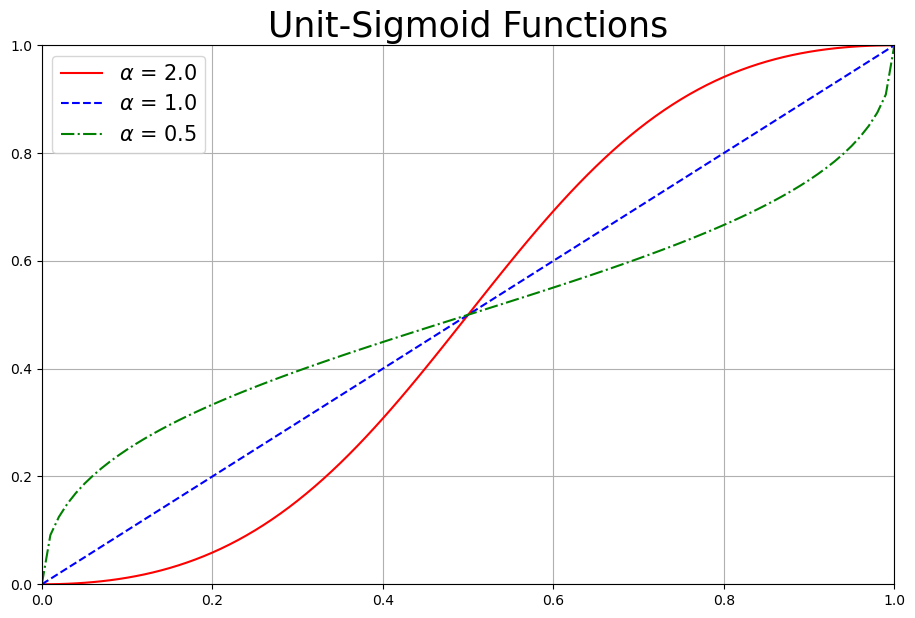

In [10]:
from utils.plot_funcs import plot_list_of_curves
from typing import Callable

VSML = 1e-8

def get_unit_sigmoid_func(alpha: float) -> Callable[[float], float]:
    return lambda x: 1. / (1+ (1 / np.where(x == 0, VSML, x) - 1) ** alpha)


alpha = [2.0, 1.0, 0.5]
colors = ["r-", "b--", "g-."]
labels = [(r"$\alpha$ = %.1f" % a) for a in alpha]
unit_sigmoids = [get_unit_sigmoid_func(a) for a in alpha]
x_vals = np.arange(0.0, 1.01, 0.01)
y_vals = [f(x_vals) for f in unit_sigmoids]
plot_list_of_curves(
    [x_vals] * len(unit_sigmoids),
    y_vals,
    colors,
    labels,
    title="Unit-Sigmoid Functions"
)

- The probability of next-up movement is dependent on the quantity $\frac{D_t}{U_t+D_t}$. $\frac{D_t}{U_t+D_t}$ is the fraction of past time steps when there was a down-move. So, if number of down-moves in history are greater than number of up-moves in history, then there will be more of an up-pull than a down-pull for the next price movement $X_{t+1}-X_t$.

- We won't satisfy the Markov Property because the probabilities of next state $S_{t+1}=X_{t+1} depends on the entire history of stock price moves and not just on the current state $S_t=X_t$.

- We can again do something clever and create a compact enough state $S_t$ consiting of simply the pair $(U_t, D_t)$. With this representation for the state $S_t$, the Markov Property is satisfied.

$$\mathbb{P}[(U_{t+1}, D_{t+1})|(U_t, D_t), (U_{t-1}, D_{t-1}), ..., (U_0, D_0)]\\
=\mathbb{P}[(U_{t+1}, D_{t+1})|(U_t, D_t)]\\
=\begin{cases}
f\left(\frac{D_t}{U_t+D_t};\alpha_3\right) & \text{if } U_{t+1}=U_t+1, D_{t+1}=D_t\\
f\left(\frac{U_t}{U_t+D_t};\alpha_3\right) & \text{if } U_{t+1}=U_t, D_{t+1}=D_t+1
\end{cases}$$

In [11]:
@dataclass
class Process3:
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int
    alpha3: float = 1.0     # strength of reverse-pull (non-negative value)
    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        if total == 0:
            return 0.5
        elif state.num_down_moves == 0:
            return state.num_down_moves ** self.alpha3
        else:
            return 1. / (1 + (total / state.num_down_moves - 1) ** self.alpha3)
        
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(
            num_up_moves=state.num_up_moves + up_move,
            num_down_moves=state.num_down_moves + 1 - up_move
        )

In [12]:
def process_price_traces(
    start_price: int,
    alpha3: float,
    times_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves
                     for s in itertools.islice(simulation(process, start_state), times_steps + 1)), float)
        for _ in range(num_traces)
    ])

In [13]:
alpha3: float = 1.0

process3_traces: np.ndarray = process_price_traces(
    start_price=start_price,
    alpha3=alpha3,
    times_steps=times_steps,
    num_traces=num_traces
)
process3_traces

array([[100., 101., 100., ..., 108., 107., 106.],
       [100., 101., 100., ...,  98.,  97.,  98.],
       [100., 101., 100., ..., 100.,  99., 100.],
       ...,
       [100.,  99., 100., ..., 110., 111., 110.],
       [100.,  99., 100., ...,  92.,  93.,  94.],
       [100.,  99., 100., ...,  96.,  97.,  98.]])

In [14]:
# plot graphs
def plot_single_trace_all_processes(
    process1_trace: np.ndarray,
    process2_trace: np.ndarray,
    process3_trace: np.ndarray
) -> None:
    from utils.plot_funcs import plot_list_of_curves

    traces_len: int = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )

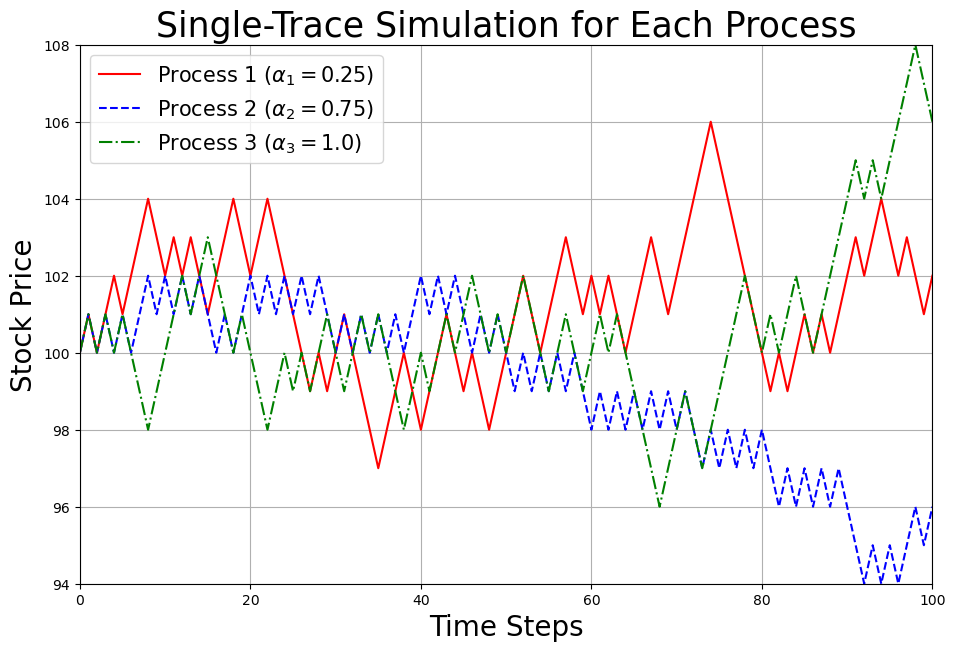

In [15]:
trace1 = process1_traces[0]
trace2 = process2_traces[0]
trace3 = process3_traces[0]

plot_single_trace_all_processes(trace1, trace2, trace3)

In [16]:
from typing import Sequence, Tuple, Counter
from operator import itemgetter

def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs: Sequence[Tuple[int, int]] = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]

In [17]:
def plot_distribution_at_time_all_processes(
    process1_traces: np.ndarray,
    process2_traces: np.ndarray,
    process3_traces: np.ndarray
) -> None:
    
    from utils.plot_funcs import plot_list_of_curves
    
    num_traces: int = len(process1_traces)
    time_steps: int = len(process1_traces[0]) - 1
    
    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)
    
    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )

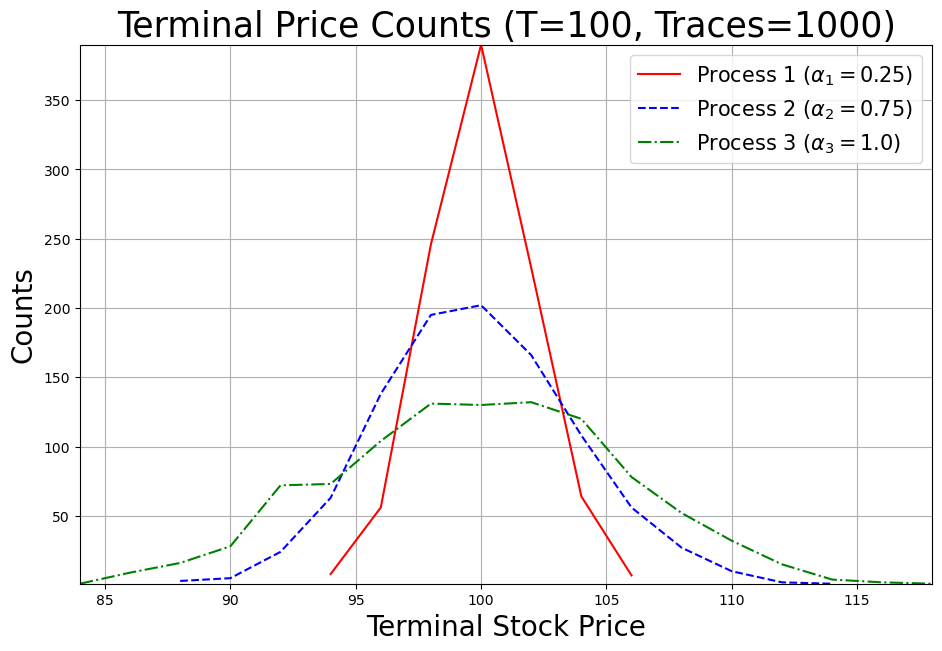

In [18]:
plot_distribution_at_time_all_processes(process1_traces, process2_traces, process3_traces)

## Formal definitions for Markov processes

- Our formal definitions will be restricted to Discrete-Time Markov processes where time moves forward in discrete time steps $t=0,1,2...$.

- A Markov process consis of

    - A countable set of states $\mathcal{S}$ and a set $\mathcal{T}\subseteq\mathcal{S}$ (known as the set of Terminal States).

    - A time-indexed sequence of random states $S_t\in\mathcal{S}$ for time steps $t=0,1,2...$ with each state transition satisfying the Markov property: $\mathbb{P}[S_{t+1}|S_t]$ for all $t\ge 0$.

    - Termination: If an outcome for $S_T$ is a state in the set $\mathcal{T}$, the this sequence outcome terminates at time step $T$.

- A time homogeneous Markov process is a Markov process with the additional property that $\mathbb{P}[S_{t+1}|S_t]$ is independent of $t$.

    - This means the dynamics of a time-homogeneous Markov process can be fully specified with the funcion

    $$\mathcal{P}:(\mathcal{S}-\mathcal{T})\times \mathcal{S}\rightarrow [0,1]$$

    - defined as:

    $$\mathcal{P}(s,s^\prime)=\mathbb{P}[S_{t+1}=s^\prime|S_t=s] \text{ for time step } t=0,1,2..., \text{ for all }s\in \mathcal{S}-\mathcal{T},s^\prime\in \mathcal{S}$$

    - such that

    $$\sum_{s^\prime\in \mathcal{S}}\mathcal{P}(s,a^\prime)=1\text{ for all }s\in \mathcal{S}-\mathcal{T}$$

    - The arguments to $\mathcal{P}$ in the above specification are devoid of the time index $t$, hence the term time-homogenous which means time-invariant.

    - A Markov process that is not time-homogenous can be converted to a time-homogeneous Markov process by augmenting all states with the time index $t$. If the original state space of a Markov process that is not time-homogeneous is $\mathcal{S}$, then the state space of the corresponding time-homogeneous Markov process is $\mathbb{Z}_{\ge 0} \times \mathcal{S}$ (where $\mathbb{Z}_{\ge 0}$ denotes the domain of the time index). This is because each time step has its own unique set of states, which means the entire set of states in $\mathbb{Z}_{\ge 0}\times \mathcal{S}$ can be covered by time-invariant transition probabilities, thus qualifying Time-Homogeneous Markov process.

- The classical definitions and theory of Markov processes model "termination" with the idea of Absorbing States. A State $s$ is called an absorbing state if $\mathcal{P}(s,s)=1$. Once we reach an absorbing state, we are trapped there. We won't consider an absorbing state as a terminal state as the Markov process keeps moving forward in time forever.


### Starting states

- We'd like to separate the following two specifications:

    - Specification of the transition probability function $\mathcal{P}$

    - Specification of the probability distribution of start states (denote this as $\mu : \mathcal{N}\rightarrow [0,1]$)

- When we want to actually play the game, we need to specify the starting point. The specification of starting positions is basically the specification of $\mu$. Given $\mu$ together with $\mathcal{P} enables us to generate sampling traces of all the Markov Process. These sampling traces enable us to answer questions such as probability distribution of states at specific future steps or expected time of first occurence of a specific state etc., given a certain starting probability distribution $\mu$.

- Thinking about the separation between sepcifying the rules of the game versus actually playing the game helps us understand the need to separate the notion of dynamics specification $\mathcal{R}$ (fundamental to the time-homogeneous sampling traces) and the notion of starting distribution $\mu$ (required to perform sampling traces).

- Hence, the separation of concerns between $\mathcal{P}$ and $\mu$ is key to the conceptualization of Markov Processes. Likewise, we separate the concertns in out code design as well, as the `next_state` method in the Process dataclasses and the `simulation` function.

### Terminal states

- If all random sequences of states reach a terminal states, then we say that these random sequences of the Markov Process are Episodic. The notion of episodic sequences is important in Reinforcement Learning since some Reinforcement Learning algorithm require episodic sequences.

- When we cover some of the financail application, we will find that the Markov Process terminates after a fixed number of time steps, say $T$. In these applications, the time index $t$ is part of the state representation, each state with time index $t=T$ is labeled a terminal state, and all states with time index $t<T$ will transition to states with time index $t+1$.

### Markov Process Implementation



- We create separate classes for non-terminal states $\mathcal{N}$ and terminal states $\mathcal{T}$, with an abstract base classes all states $\mathcal{S}$. The abstract base class (ABC) `State` represent $\mathcal{S}$. The class `State` is parameterized by a generic type (`TypeVar('S')`) representing a generic state space `Generic[S]`.

- The method `on_non_terminal` will prove to be very beneficial in the implementation of various algorithms for Markov Processes and for Markov Reward Processes and Markov Decision Processes. It enables us to calculate a value for all states in $\mathcal{S}$ even though the calculation is defined only for all non-terminal states $\mathcal{N}$. 

- The argument `f` to `on_non_terminl` defines this value through a function from $\mathcal{N}$ to an arbitrary value-type `X`. The argument `default` provides the default value for terminal states $\mathcal{T}$ so that `on_non_terminal` can be used on any object in `State`.

- By defining (defaulting) this value to be 0 for terminal states, we can then invoke such a calculation for all states $\mathcal{S}$, terminal or non-termnal, and embed this calculation in an algorithm without worrying about special handing in the code for the edge case of being a terminal state.

In [ ]:
from abc import ABC
from dataclasses import dataclass
from typing import Generic, Callable, TypeVar

S = TypeVar('S')
X = TypeVar('X')

class State(ABC, Generic[S]):
    state: S
    def on_non_terminal(
        self, 
        f: Callable[[NonTerminal[S]], X],
        default: X
    ) -> X:
        if isinstance(self, NonTerminal):
            return f(self)
        else:
            return default
    
@dataclass(frozen=True)
class Terminal(State[S]):
    state: S
    
@dataclass(frozen=True)
class NonTerminal(State[S]):
    state: S